In [261]:
!pip install scikit-learn
!pip install graphviz
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install seaborn

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt # data visualization
#import matplotlib.pyplot as plt
import seaborn as sns #data visualization
import random 

random.seed(1)
pokemon = pd.read_csv("pokemon.csv", header = 0)
combat = pd.read_csv("combats.partial.csv", header = 0)
combat.head()

,Winner,First_pokemon,Second_pokemon
0,650,650,579
1,151,151,558
2,340,340,631
3,139,688,139
4,132,365,132


In [3]:
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [4]:
#stampiamo il numero di dati a disposizione
print("Dimensione di Pokemon: " + str(pokemon.shape))
print("Dimensione di Combat: " + str(combat.shape))

Dimensione di Pokemon: (800, 12)
Dimensione di Combat: (40000, 3)


In [5]:
#Vediamo se ci sono dei dati mancanti
#se una feature ha tanti dati mancanti, potrebbe avere senso scartarla
pokemon.isnull().sum()

#               0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [6]:
combat.isnull().sum()

Winner            0
First_pokemon     0
Second_pokemon    0
dtype: int64

In [7]:
#Rinomino per comodità la colonna id
pokemon.rename(columns={'#': 'id'}, inplace=True)


In [8]:
#il nome ha un elemento pari a null. Sicuramente però non serve per effettuare l'addestramento
#la generazione indica solo la stagione il cui il pokemon è comparso per la prima volta
pokemon = pokemon.drop(['Name','Generation'],1)
#I pokemon hanno un tipo primario ma non necessariamente secondario, e quindi molti pokemon hanno Type 2 nullo.
#Type 2 ha tanti elementi nulli, quindi questa features può essere scartata
pokemon = pokemon.drop(['Type 2'],1)
pokemon.head()

,id,Type 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Grass,45,49,49,65,65,45,False
1,2,Grass,60,62,63,80,80,60,False
2,3,Grass,80,82,83,100,100,80,False
3,4,Grass,80,100,123,122,120,80,False
4,5,Fire,39,52,43,60,50,65,False


In [9]:
#Verifico di non avere più dati nulli
pokemon.isnull().sum()

id           0
Type 1       0
HP           0
Attack       0
Defense      0
Sp. Atk      0
Sp. Def      0
Speed        0
Legendary    0
dtype: int64

In [12]:
#statistiche di base
pokemon.describe()

,id,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


In [18]:
#Vediamo se c'è qualche pokemon che non ha mai vinto 

#Numero di vittorie di ogni pokemon in ordine decrescente
#Se un pokemon non ha mai vinto non compare in total_Wins
total_Wins = combat.Winner.value_counts()
#Conto il numero di pokemon che compare come "secondo pokemon"
#Contare il numero di pokemon che compaiono come "primo pokemon" produce lo stesso risultato
countByFirst = combat.groupby('Second_pokemon').count()
countBySecond = combat.groupby('First_pokemon').count()

#se la dimesione di total_wins è minore di count by first, allora qualche pokemon non ha mai vinto
print("CountByFirst: " + str(countByFirst.shape))
print("total_Wins : " + str(total_Wins.shape))

CountByFirst: (784, 2)
total_Wins : (783,)


In [19]:
#Esiste quindi un pokemon che non ha mai vinto.Cerco quale è
numberOfWins = combat.groupby('Winner').count()
find_losing_pokemon= np.setdiff1d(countByFirst.index.values, numberOfWins.index.values)-1 #offset because the index and number are off by one
losing_pokemon = pokemon.iloc[find_losing_pokemon[0],]
print(losing_pokemon)

id             231
Type 1         Bug
HP              20
Attack          10
Defense        230
Sp. Atk         10
Sp. Def        230
Speed            5
Legendary    False
Name: 230, dtype: object


In [20]:
#Esiste qualche pokemon che non ha fatto nemmeno una sfida?
#Numero di vittorie di ogni pokemon 
numberOfWins = combat.groupby('Winner').count()

numberOfWins = numberOfWins.sort_index() #ordiniamo per indici crescenti
numberOfWins['Total Fights'] = countByFirst.Winner + countBySecond.Winner
numberOfWins['Win Percentage']= numberOfWins.First_pokemon/numberOfWins['Total Fights']

#Ad ogni pokemon aggiungo il numero di vittorie e la percentuale di vittorie
results2 = pd.merge(pokemon, numberOfWins, right_index = True, left_on='id')
results3 = pd.merge(pokemon, numberOfWins, left_on='id', right_index = True, how='left')

#strampa i dataframe la cui percentuale di vincita è null (ovvero quelli che non hanno mai vinto o non hanno mai fatto una sfida)
results3[results3['Win Percentage'].isnull()].head()

,id,Type 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,First_pokemon,Second_pokemon,Total Fights,Win Percentage
11,12,Water,79,83,100,85,105,78,False,NaN,NaN,NaN,NaN
32,33,Ground,50,75,85,20,30,40,False,NaN,NaN,NaN,NaN
45,46,Normal,140,70,45,85,50,45,False,NaN,NaN,NaN,NaN
65,66,Water,40,50,40,40,40,90,False,NaN,NaN,NaN,NaN
77,78,Grass,80,105,65,100,70,70,False,NaN,NaN,NaN,NaN


In [21]:
#Esitono quindi dei pokemon che non compaiono nemmeno una volta nel training set



#Ordino per valori decrescenti della percentuale di vincita
results3[np.isfinite(results3['Win Percentage'])].sort_values(by = ['Win Percentage']).head()

,id,Type 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,First_pokemon,Second_pokemon,Total Fights,Win Percentage
236,237,Fire,40,40,40,70,40,20,False,2.0,2.0,96.0,0.020833
576,577,Psychic,76,25,45,67,55,24,False,3.0,3.0,105.0,0.028571
289,290,Bug,50,35,55,25,25,15,False,3.0,3.0,98.0,0.030612
189,190,Fairy,35,20,65,40,65,20,False,3.0,3.0,94.0,0.031915
638,639,Psychic,45,30,40,105,50,20,False,4.0,4.0,103.0,0.038835


In [22]:
results3.groupby('Type 1').agg({"Win Percentage": "mean"}).sort_values(by = "Win Percentage")
#vediamo che relazione c'è tra la percentuale di vincita ed il tipo 1

,Win Percentage
Type 1,
Fairy,0.331437
Rock,0.404328
Steel,0.421883
Ice,0.434821
Grass,0.436504
Bug,0.437356
Poison,0.440285
Water,0.467251
Fighting,0.475921


In [23]:
#flyng, dragon ed electric hanno la più alta percentuale di vincita
#forse la tipologgia di attacchi che questi pokemon possono sferrare, sono 
#più efficaci degli altri

Text(0.5, 1.0, 'Total Pokemon by Type 1')

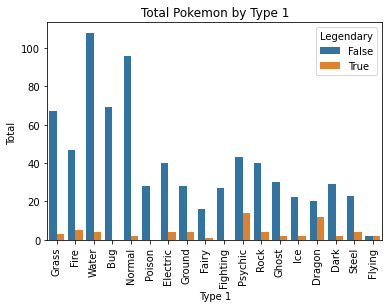

In [24]:
import matplotlib.pyplot as plt

#Vediamo i vari pokemon come si distribuiscono nelle varie tipologie
sns.set_color_codes("pastel")
ax = sns.countplot(x="Type 1", hue="Legendary", data=results3)
#f.set_xticklabels(rotation=30)
plt.xticks(rotation= 90)
plt.xlabel('Type 1')
plt.ylabel('Total ')
plt.title("Total Pokemon by Type 1")

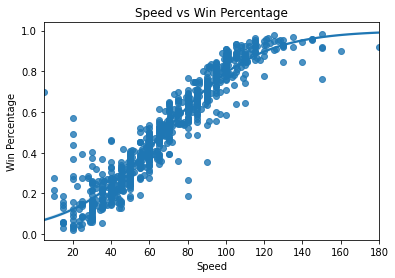

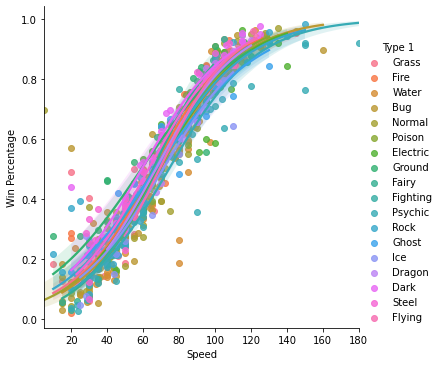

In [25]:
#la maggior parte dei pokemon è di tipo water, bug, Normal, e grass
#La categoria meno numerosa è Flyng. Nostante Flyng abbia pochi elementi, è il tipo con percentuale di vittorie più alta (pochi ma buoni)


#Vediamo ora se c'è qualche correlazione tra la percentuale di vincita e le features
import matplotlib.pyplot as plt
#f, (ax1, ax2) = plt.subplots(1,2)
sns.regplot(x="Speed", y="Win Percentage", data=results3, logistic=True).set_title("Speed vs Win Percentage")
sns.lmplot(x="Speed", y="Win Percentage", data=results3, hue = 'Type 1',  logistic=True)#.set_title("Speed vs Win Percentage")

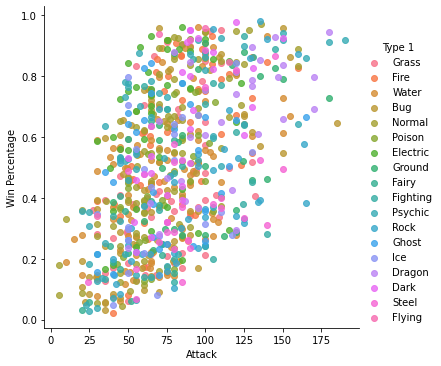

In [26]:
#sembrerebbe esserci una certa correlazione tra la velocità del pokemon e la probabilità di vincita

#Vediamo se c'è anche qualche relazione tra la potenza dell'attacco e la percentuale di vincita
sns.lmplot(x="Attack", y="Win Percentage", data=results3, hue = 'Type 1',fit_reg =False)

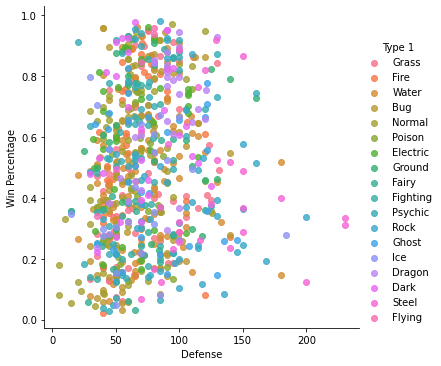

In [27]:
#All' aumentare della potenza dell'attacco, la percentuale di vincita aumenta, indipendentemente
#dalla tipologia di pokemon


#Vediamo se c'è anche qualche relazione tra la difesa e la percentuale di vincita
sns.lmplot(x="Defense", y="Win Percentage", data=results3, hue = 'Type 1',fit_reg =False)

In [ ]:
#il grafico della difesa non ci dice niente di interessante
#elimino utleriori features perché tanto il maggior contenuto informatico è dato dall'attacco, indipendentemente dal 
#tipo di pokemon o se è leggendario o no
pokemon = pokemon.drop(['Type 1','Legendary'],1)

In [30]:
from sklearn.model_selection import train_test_split

#Per la classificazione, quello che conta è la differrenza dei valori delle features tra i due pokemon che si sfidano
#modifico 


#come features per il train e il test, uso la differenza tra le features del primo pokemon e del secondo pokemon in ogni scontro
#ad ogni riga di combat aggiungo quindi le features del primo pokemon e quelle del secondo
combat = combat.join(pokemon.add_suffix('_first').set_index('id_first'), on='First_pokemon')
combat = combat.join(pokemon.add_suffix('_second').set_index('id_second'), on='Second_pokemon')

#aggiungo anche la differenza tra le features dei due pokemon
combat["HP_diff"] = combat["HP_first"] - combat["HP_second"]
combat["Attack_diff"] = combat["Attack_first"] - combat["Attack_second"]
combat["Defense_diff"] = combat["Defense_first"] - combat["Defense_second"]
combat["Sp. Atk_diff"] = combat["Sp. Atk_first"] - combat["Sp. Atk_second"]
combat["Sp. Def_diff"] = combat["Sp. Def_first"] - combat["Sp. Def_second"]
combat["Speed_diff"] = combat["Speed_first"] - combat["Speed_second"]

#Per comodità aggiungo una feature, che sarà il target, che vale 1 se è il primo pokemon a vincere e 2 se è il secondo
combat['WTag'] = np.where((combat['Winner'] == combat['First_pokemon']), 1, 2)

train, test = train_test_split(combat, random_state=42,test_size=0.25)    # divido i dati tra train e test set

#save the data
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)